In [1]:
from utils import *

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import folium

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, accuracy_score

import optuna
from optuna.trial import TrialState

/home/guilhermemaciel/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Carregando o dataset

In [2]:
df_train = pd.read_csv('../data/balanced_data/train.csv')
df_val = pd.read_csv('../data/balanced_data/validation.csv')
df_test = pd.read_csv('../data/balanced_data/test.csv')

Concatenando os datasets de treino e validação, pois o Random Forest não necessita de validação

In [3]:
df_train = pd.concat([df_train, df_val], ignore_index=False)

In [4]:
df_train.head()

,ponto_id,rssi_1_1,rssi_1_2,rssi_1_3,rssi_2_1,rssi_2_2,rssi_2_3,rssi_3_1,rssi_3_2,rssi_3_3,delay_1,delay_2,delay_3,lat,lon,indoor
0,6659,0.490595,0.592069,0.473746,0.305143,0.748657,0.867459,0.332333,0.426865,0.306476,1.000000,0.285714,0.714286,-8.058890,-34.946260,False
1,4799,0.316859,0.000000,0.303716,0.000000,0.209296,0.239055,0.124152,0.277901,0.000000,0.666667,0.428571,0.285714,-8.055506,-34.951693,True
2,7057,0.420978,0.374651,0.412409,0.261084,0.398934,0.492072,0.773747,0.712558,0.294188,0.666667,0.571429,0.142857,-8.055580,-34.954590,False
3,7408,0.472425,0.307408,0.482708,0.224991,0.264643,0.472029,0.816936,0.455887,0.855267,0.666667,0.857143,0.000000,-8.054870,-34.957800,False
4,6959,0.534422,0.307408,0.539420,0.259290,0.264643,0.523022,0.389744,0.515420,0.671150,0.833333,0.857143,0.000000,-8.055760,-34.958900,False


In [5]:
X_train = df_train.drop(['ponto_id', 'indoor', 'lat', 'lon'], axis=1).values
y_train = df_train[['lat', 'lon']].values

X_test = df_test.drop(['ponto_id', 'indoor', 'lat', 'lon'], axis=1).values
y_test = df_test[['lat', 'lon']].values

In [24]:
model = RandomForestRegressor(
    n_estimators=10,
    max_depth=10,
    criterion='squared_error',
    min_samples_leaf=1,
    max_features=df_train.shape[1],
    random_state=51
)

In [25]:
model.fit(X=X_train, y=y_train)

RandomForestRegressor(max_depth=10, max_features=16, n_estimators=10,
                      random_state=51)

## Avaliando o modelo

#### Conjunto de Teste

In [26]:
y_pred_test_class = model.predict(X_test)

rmse = np.sqrt(root_mean_squared_error(y_test, y_pred_test_class))
print(f'RMSE: {rmse}')

RMSE: 0.011987589275663046


In [27]:
accuracy = calculate_accuracy(y_pred_test_class, y_test)
print(f"Acurácia: {accuracy:.3f}")


Acurácia: 0.818


In [29]:
model.score(X_test, y_test)

0.9965164394919961

Erro de localização médio, mínimo, máximo e desvio-padrão

In [10]:
distances = get_error_distances(y_pred_test_class, y_test)

In [11]:
print_errors(distances)

Erro de localização médio: 7.988 metros
Erro mínimo: 3.922874968612674e-09 metros
Erro máximo: 313.430 metros
Desvio Padrão do erro: 21.037 metros


#### BoxPlot

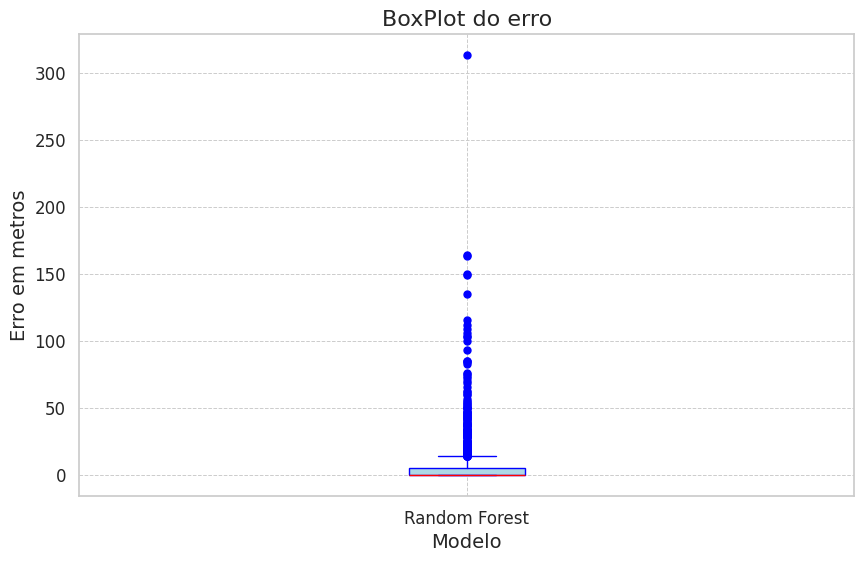

In [12]:
plot_boxplot('Random Forest', distances)

#### Histograma dos Erros

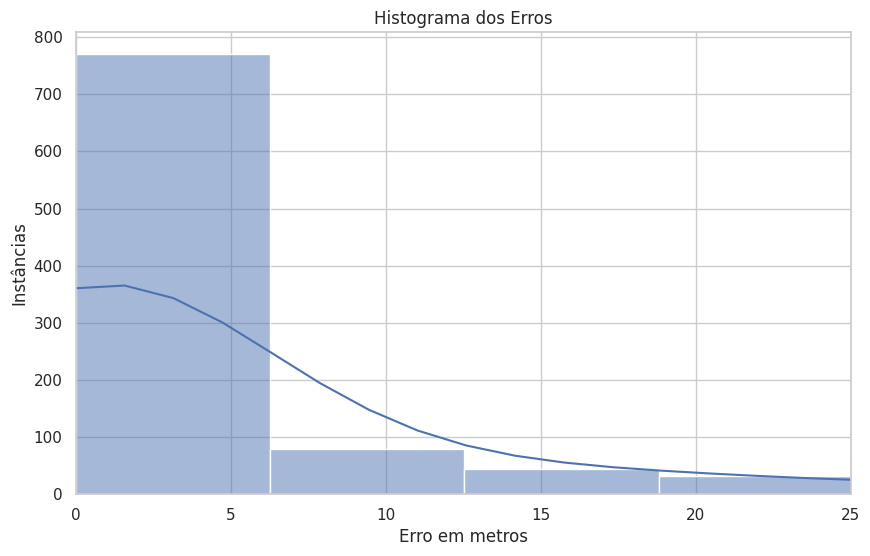

In [13]:
plot_histogram(distances)

In [14]:
print(f"Total de distâncias: {len(distances)}")
print(f"Distâncias com menos de 25 Metros de erro: {np.sum(distances <= 25)}")

Total de distâncias: 1017
Distâncias com menos de 25 Metros de erro: 927


#### Visualização dos Mapas

In [15]:
map = plot_folium_map(y_test, y_pred_test_class, True)
map

In [16]:
map = plot_folium_map(y_test, y_pred_test_class, False)
map

#### Avaliando o modelos para pontos específicos 

In [17]:
# Prevendo o valor de uma instância específica
idx = 75

X_unit = X_test[idx].reshape(1, -1)
y_unit = np.array([y_test[idx]])
y_pred_unit = model.predict(X_unit)

print(f"Pred Point: {y_pred_unit[0]}")
print(f"Real Point: {y_unit[0]}")

Pred Point: [ -8.04849345 -34.94598896]
Real Point: [ -8.04945 -34.94577]


In [18]:
map = plot_folium_map(y_unit, y_pred_unit, True)
map

#### Usando o Optune para encontrar os melhores Hiperparâmetros

#### Primeiro iremos criar uma função objetivo, com foco em maximizar o AOC

In [19]:
def objective(trial):

    global x_train
    global y_train

    global X_test
    global y_test
    
    # Sugerir valores para os hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    trial.set_user_attr("n_estimators", n_estimators)
    trial.set_user_attr("max_depth", max_depth)
    trial.set_user_attr("min_samples_split", min_samples_split)
    trial.set_user_attr("min_samples_leaf", min_samples_leaf)
    
    # Criar o modelo RandomForest com os hiperparâmetros sugeridos
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=51,
        criterion='squared_error',
    )

    model.fit(X=X_train, y=y_train)
    
    # Avaliar o modelo usando test k-s
    y_pred_test_class = model.predict(X_test)
    rmse = np.sqrt(root_mean_squared_error(y_test, y_pred_test_class))
    accuracy = calculate_accuracy(y_pred_test_class, y_test)
    
    print(f'\n\nRandom Forest\nn_estimators: {n_estimators}\nmax_depth:{max_depth}\nmin_samples_split:{min_samples_split}\nmin_samples_leaf:{min_samples_leaf}')
    print(f'RMSE: {rmse}\nAccuracy: {accuracy:.3f}')
    

    trial.set_user_attr("RMSE", rmse)
    trial.set_user_attr("Accuracy", accuracy)
    
    return rmse


In [20]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-08-06 19:46:04,502] A new study created in memory with name: no-name-9b29e770-0b6f-4590-b1c4-afefe4672c02
[I 2024-08-06 19:46:06,859] Trial 0 finished with value: 0.01241694033923496 and parameters: {'n_estimators': 90, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.01241694033923496.




Random Forest
n_estimators: 90
max_depth:18
min_samples_split:7
min_samples_leaf:7
RMSE: 0.01241694033923496
Accuracy: 0.815


[I 2024-08-06 19:46:16,914] Trial 1 finished with value: 0.012403275166706808 and parameters: {'n_estimators': 365, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.012403275166706808.




Random Forest
n_estimators: 365
max_depth:16
min_samples_split:3
min_samples_leaf:6
RMSE: 0.012403275166706808
Accuracy: 0.819


[I 2024-08-06 19:46:25,680] Trial 2 finished with value: 0.014615786203421488 and parameters: {'n_estimators': 398, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.012403275166706808.




Random Forest
n_estimators: 398
max_depth:7
min_samples_split:5
min_samples_leaf:7
RMSE: 0.014615786203421488
Accuracy: 0.349


[I 2024-08-06 19:46:29,033] Trial 3 finished with value: 0.02801128246262496 and parameters: {'n_estimators': 274, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.012403275166706808.




Random Forest
n_estimators: 274
max_depth:3
min_samples_split:6
min_samples_leaf:7
RMSE: 0.02801128246262496
Accuracy: 0.002


[I 2024-08-06 19:46:37,415] Trial 4 finished with value: 0.011944707326872115 and parameters: {'n_estimators': 291, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 4 with value: 0.011944707326872115.




Random Forest
n_estimators: 291
max_depth:11
min_samples_split:8
min_samples_leaf:1
RMSE: 0.011944707326872115
Accuracy: 0.837


[I 2024-08-06 19:46:44,864] Trial 5 finished with value: 0.01457281879292414 and parameters: {'n_estimators': 331, 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 2}. Best is trial 4 with value: 0.011944707326872115.




Random Forest
n_estimators: 331
max_depth:7
min_samples_split:15
min_samples_leaf:2
RMSE: 0.01457281879292414
Accuracy: 0.348


[I 2024-08-06 19:46:48,436] Trial 6 finished with value: 0.013227089119532482 and parameters: {'n_estimators': 148, 'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 2}. Best is trial 4 with value: 0.011944707326872115.




Random Forest
n_estimators: 148
max_depth:8
min_samples_split:15
min_samples_leaf:2
RMSE: 0.013227089119532482
Accuracy: 0.554


[I 2024-08-06 19:46:59,941] Trial 7 finished with value: 0.012225635187348965 and parameters: {'n_estimators': 414, 'max_depth': 19, 'min_samples_split': 11, 'min_samples_leaf': 4}. Best is trial 4 with value: 0.011944707326872115.




Random Forest
n_estimators: 414
max_depth:19
min_samples_split:11
min_samples_leaf:4
RMSE: 0.012225635187348965
Accuracy: 0.833


[I 2024-08-06 19:47:05,674] Trial 8 finished with value: 0.014709702843523702 and parameters: {'n_estimators': 289, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 4 with value: 0.011944707326872115.




Random Forest
n_estimators: 289
max_depth:7
min_samples_split:10
min_samples_leaf:10
RMSE: 0.014709702843523702
Accuracy: 0.349


[I 2024-08-06 19:47:08,396] Trial 9 finished with value: 0.012469475605548909 and parameters: {'n_estimators': 152, 'max_depth': 13, 'min_samples_split': 12, 'min_samples_leaf': 7}. Best is trial 4 with value: 0.011944707326872115.




Random Forest
n_estimators: 152
max_depth:13
min_samples_split:12
min_samples_leaf:7
RMSE: 0.012469475605548909
Accuracy: 0.810


[I 2024-08-06 19:47:19,079] Trial 10 finished with value: 0.01174581261196233 and parameters: {'n_estimators': 500, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 10 with value: 0.01174581261196233.




Random Forest
n_estimators: 500
max_depth:12
min_samples_split:2
min_samples_leaf:1
RMSE: 0.01174581261196233
Accuracy: 0.846


[I 2024-08-06 19:47:30,705] Trial 11 finished with value: 0.011756431685921265 and parameters: {'n_estimators': 483, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 10 with value: 0.01174581261196233.




Random Forest
n_estimators: 483
max_depth:12
min_samples_split:2
min_samples_leaf:1
RMSE: 0.011756431685921265
Accuracy: 0.847


[I 2024-08-06 19:47:43,245] Trial 12 finished with value: 0.012137042776775164 and parameters: {'n_estimators': 500, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 10 with value: 0.01174581261196233.




Random Forest
n_estimators: 500
max_depth:14
min_samples_split:2
min_samples_leaf:4
RMSE: 0.012137042776775164
Accuracy: 0.833


[I 2024-08-06 19:47:57,651] Trial 13 finished with value: 0.011797958068136657 and parameters: {'n_estimators': 498, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 10 with value: 0.01174581261196233.




Random Forest
n_estimators: 498
max_depth:11
min_samples_split:4
min_samples_leaf:1
RMSE: 0.011797958068136657
Accuracy: 0.840


[I 2024-08-06 19:48:09,693] Trial 14 finished with value: 0.012102491395440848 and parameters: {'n_estimators': 436, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 10 with value: 0.01174581261196233.




Random Forest
n_estimators: 436
max_depth:10
min_samples_split:2
min_samples_leaf:3
RMSE: 0.012102491395440848
Accuracy: 0.818


[I 2024-08-06 19:48:22,998] Trial 15 finished with value: 0.01216448043968009 and parameters: {'n_estimators': 461, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 10 with value: 0.01174581261196233.




Random Forest
n_estimators: 461
max_depth:15
min_samples_split:4
min_samples_leaf:4
RMSE: 0.01216448043968009
Accuracy: 0.834


[I 2024-08-06 19:48:25,503] Trial 16 finished with value: 0.02800111067286218 and parameters: {'n_estimators': 210, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 10 with value: 0.01174581261196233.




Random Forest
n_estimators: 210
max_depth:3
min_samples_split:2
min_samples_leaf:10
RMSE: 0.02800111067286218
Accuracy: 0.002


[I 2024-08-06 19:48:26,508] Trial 17 finished with value: 0.011880142899987348 and parameters: {'n_estimators': 34, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 10 with value: 0.01174581261196233.




Random Forest
n_estimators: 34
max_depth:13
min_samples_split:6
min_samples_leaf:1
RMSE: 0.011880142899987348
Accuracy: 0.836


[I 2024-08-06 19:48:37,043] Trial 18 finished with value: 0.012010151880811658 and parameters: {'n_estimators': 360, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 10 with value: 0.01174581261196233.




Random Forest
n_estimators: 360
max_depth:17
min_samples_split:4
min_samples_leaf:3
RMSE: 0.012010151880811658
Accuracy: 0.841


[I 2024-08-06 19:48:48,690] Trial 19 finished with value: 0.012551331669450282 and parameters: {'n_estimators': 452, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 10 with value: 0.01174581261196233.




Random Forest
n_estimators: 452
max_depth:9
min_samples_split:9
min_samples_leaf:5
RMSE: 0.012551331669450282
Accuracy: 0.798


[I 2024-08-06 19:48:52,876] Trial 20 finished with value: 0.01977217335844633 and parameters: {'n_estimators': 236, 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 2}. Best is trial 10 with value: 0.01174581261196233.




Random Forest
n_estimators: 236
max_depth:5
min_samples_split:13
min_samples_leaf:2
RMSE: 0.01977217335844633
Accuracy: 0.001


[I 2024-08-06 19:49:07,845] Trial 21 finished with value: 0.011769840352868127 and parameters: {'n_estimators': 496, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 10 with value: 0.01174581261196233.




Random Forest
n_estimators: 496
max_depth:12
min_samples_split:4
min_samples_leaf:1
RMSE: 0.011769840352868127
Accuracy: 0.844


[I 2024-08-06 19:49:22,887] Trial 22 finished with value: 0.01174224772478761 and parameters: {'n_estimators': 497, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 497
max_depth:12
min_samples_split:3
min_samples_leaf:1
RMSE: 0.01174224772478761
Accuracy: 0.849


[I 2024-08-06 19:49:34,340] Trial 23 finished with value: 0.012033751716673218 and parameters: {'n_estimators': 387, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 387
max_depth:14
min_samples_split:3
min_samples_leaf:3
RMSE: 0.012033751716673218
Accuracy: 0.837


[I 2024-08-06 19:49:46,780] Trial 24 finished with value: 0.012021655627475978 and parameters: {'n_estimators': 437, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 437
max_depth:10
min_samples_split:2
min_samples_leaf:2
RMSE: 0.012021655627475978
Accuracy: 0.821


[I 2024-08-06 19:50:00,638] Trial 25 finished with value: 0.011852405074506663 and parameters: {'n_estimators': 467, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 467
max_depth:12
min_samples_split:6
min_samples_leaf:1
RMSE: 0.011852405074506663
Accuracy: 0.840


[I 2024-08-06 19:50:10,918] Trial 26 finished with value: 0.01188111429020663 and parameters: {'n_estimators': 336, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 336
max_depth:15
min_samples_split:3
min_samples_leaf:2
RMSE: 0.01188111429020663
Accuracy: 0.844


[I 2024-08-06 19:50:21,171] Trial 27 finished with value: 0.012672516382655676 and parameters: {'n_estimators': 422, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 422
max_depth:20
min_samples_split:3
min_samples_leaf:9
RMSE: 0.012672516382655676
Accuracy: 0.796


[I 2024-08-06 19:50:33,539] Trial 28 finished with value: 0.01233923805858863 and parameters: {'n_estimators': 470, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 470
max_depth:9
min_samples_split:5
min_samples_leaf:3
RMSE: 0.01233923805858863
Accuracy: 0.799


[I 2024-08-06 19:50:44,414] Trial 29 finished with value: 0.01229610813033751 and parameters: {'n_estimators': 395, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 395
max_depth:13
min_samples_split:8
min_samples_leaf:5
RMSE: 0.01229610813033751
Accuracy: 0.828


[I 2024-08-06 19:50:45,075] Trial 30 finished with value: 0.012068592697873139 and parameters: {'n_estimators': 21, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 21
max_depth:16
min_samples_split:7
min_samples_leaf:1
RMSE: 0.012068592697873139
Accuracy: 0.835


[I 2024-08-06 19:50:59,693] Trial 31 finished with value: 0.011770371536637528 and parameters: {'n_estimators': 495, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 495
max_depth:12
min_samples_split:4
min_samples_leaf:1
RMSE: 0.011770371536637528
Accuracy: 0.844


[I 2024-08-06 19:51:12,899] Trial 32 finished with value: 0.011915373934110107 and parameters: {'n_estimators': 470, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 470
max_depth:11
min_samples_split:5
min_samples_leaf:2
RMSE: 0.011915373934110107
Accuracy: 0.837


[I 2024-08-06 19:51:22,092] Trial 33 finished with value: 0.011937413546036819 and parameters: {'n_estimators': 484, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 484
max_depth:10
min_samples_split:3
min_samples_leaf:1
RMSE: 0.011937413546036819
Accuracy: 0.819


[I 2024-08-06 19:51:32,086] Trial 34 finished with value: 0.01187311223354316 and parameters: {'n_estimators': 438, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 438
max_depth:14
min_samples_split:2
min_samples_leaf:2
RMSE: 0.01187311223354316
Accuracy: 0.843


[I 2024-08-06 19:51:42,039] Trial 35 finished with value: 0.012564366622446152 and parameters: {'n_estimators': 371, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 371
max_depth:12
min_samples_split:3
min_samples_leaf:8
RMSE: 0.012564366622446152
Accuracy: 0.800


[I 2024-08-06 19:51:54,142] Trial 36 finished with value: 0.011766991805676374 and parameters: {'n_estimators': 410, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 410
max_depth:17
min_samples_split:5
min_samples_leaf:1
RMSE: 0.011766991805676374
Accuracy: 0.844


[I 2024-08-06 19:52:05,472] Trial 37 finished with value: 0.012003674798419335 and parameters: {'n_estimators': 416, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 416
max_depth:18
min_samples_split:5
min_samples_leaf:3
RMSE: 0.012003674798419335
Accuracy: 0.840


[I 2024-08-06 19:52:14,699] Trial 38 finished with value: 0.012414311978480605 and parameters: {'n_estimators': 336, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 336
max_depth:17
min_samples_split:7
min_samples_leaf:6
RMSE: 0.012414311978480605
Accuracy: 0.820


[I 2024-08-06 19:52:28,191] Trial 39 finished with value: 0.011900632123535005 and parameters: {'n_estimators': 457, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 457
max_depth:16
min_samples_split:2
min_samples_leaf:2
RMSE: 0.011900632123535005
Accuracy: 0.845


[I 2024-08-06 19:52:37,990] Trial 40 finished with value: 0.013171627091696605 and parameters: {'n_estimators': 404, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 404
max_depth:8
min_samples_split:5
min_samples_leaf:1
RMSE: 0.013171627091696605
Accuracy: 0.549


[I 2024-08-06 19:52:46,734] Trial 41 finished with value: 0.011774044597488396 and parameters: {'n_estimators': 479, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 479
max_depth:13
min_samples_split:4
min_samples_leaf:1
RMSE: 0.011774044597488396
Accuracy: 0.847


[I 2024-08-06 19:53:01,416] Trial 42 finished with value: 0.011859156194312753 and parameters: {'n_estimators': 498, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 498
max_depth:15
min_samples_split:3
min_samples_leaf:2
RMSE: 0.011859156194312753
Accuracy: 0.844


[I 2024-08-06 19:53:14,134] Trial 43 finished with value: 0.011820852565349827 and parameters: {'n_estimators': 443, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 443
max_depth:11
min_samples_split:4
min_samples_leaf:1
RMSE: 0.011820852565349827
Accuracy: 0.841


[I 2024-08-06 19:53:26,760] Trial 44 finished with value: 0.011846898209272358 and parameters: {'n_estimators': 429, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 429
max_depth:12
min_samples_split:6
min_samples_leaf:1
RMSE: 0.011846898209272358
Accuracy: 0.842


[I 2024-08-06 19:53:36,303] Trial 45 finished with value: 0.016617972737216217 and parameters: {'n_estimators': 476, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 476
max_depth:6
min_samples_split:2
min_samples_leaf:2
RMSE: 0.016617972737216217
Accuracy: 0.088


[I 2024-08-06 19:53:48,330] Trial 46 finished with value: 0.012337513815287936 and parameters: {'n_estimators': 453, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 453
max_depth:9
min_samples_split:3
min_samples_leaf:3
RMSE: 0.012337513815287936
Accuracy: 0.800


[I 2024-08-06 19:53:56,871] Trial 47 finished with value: 0.011943999638377539 and parameters: {'n_estimators': 305, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 305
max_depth:10
min_samples_split:4
min_samples_leaf:1
RMSE: 0.011943999638377539
Accuracy: 0.820


[I 2024-08-06 19:54:00,959] Trial 48 finished with value: 0.012132368950248537 and parameters: {'n_estimators': 143, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 143
max_depth:14
min_samples_split:2
min_samples_leaf:4
RMSE: 0.012132368950248537
Accuracy: 0.839


[I 2024-08-06 19:54:15,645] Trial 49 finished with value: 0.011860500796180973 and parameters: {'n_estimators': 500, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 500
max_depth:20
min_samples_split:5
min_samples_leaf:2
RMSE: 0.011860500796180973
Accuracy: 0.842


[I 2024-08-06 19:54:27,360] Trial 50 finished with value: 0.011749969094365317 and parameters: {'n_estimators': 379, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 379
max_depth:18
min_samples_split:3
min_samples_leaf:1
RMSE: 0.011749969094365317
Accuracy: 0.850


[I 2024-08-06 19:54:38,440] Trial 51 finished with value: 0.011758530961371772 and parameters: {'n_estimators': 358, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 358
max_depth:18
min_samples_split:3
min_samples_leaf:1
RMSE: 0.011758530961371772
Accuracy: 0.848


[I 2024-08-06 19:54:49,531] Trial 52 finished with value: 0.011765014152661964 and parameters: {'n_estimators': 355, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 355
max_depth:19
min_samples_split:3
min_samples_leaf:1
RMSE: 0.011765014152661964
Accuracy: 0.847


[I 2024-08-06 19:54:59,095] Trial 53 finished with value: 0.011920536242541833 and parameters: {'n_estimators': 314, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 314
max_depth:19
min_samples_split:2
min_samples_leaf:2
RMSE: 0.011920536242541833
Accuracy: 0.843


[I 2024-08-06 19:55:07,795] Trial 54 finished with value: 0.011782881697715472 and parameters: {'n_estimators': 268, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 268
max_depth:19
min_samples_split:3
min_samples_leaf:1
RMSE: 0.011782881697715472
Accuracy: 0.853


[I 2024-08-06 19:55:19,351] Trial 55 finished with value: 0.011891034648355212 and parameters: {'n_estimators': 366, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 366
max_depth:18
min_samples_split:3
min_samples_leaf:2
RMSE: 0.011891034648355212
Accuracy: 0.841


[I 2024-08-06 19:55:26,820] Trial 56 finished with value: 0.01176460290187423 and parameters: {'n_estimators': 229, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 229
max_depth:18
min_samples_split:2
min_samples_leaf:1
RMSE: 0.01176460290187423
Accuracy: 0.850


[I 2024-08-06 19:55:32,318] Trial 57 finished with value: 0.012136309492463403 and parameters: {'n_estimators': 185, 'max_depth': 17, 'min_samples_split': 14, 'min_samples_leaf': 3}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 185
max_depth:17
min_samples_split:14
min_samples_leaf:3
RMSE: 0.012136309492463403
Accuracy: 0.817


[I 2024-08-06 19:55:39,424] Trial 58 finished with value: 0.011972208192757048 and parameters: {'n_estimators': 240, 'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 1}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 240
max_depth:18
min_samples_split:11
min_samples_leaf:1
RMSE: 0.011972208192757048
Accuracy: 0.832


[I 2024-08-06 19:55:45,475] Trial 59 finished with value: 0.011900249592747238 and parameters: {'n_estimators': 216, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 216
max_depth:20
min_samples_split:2
min_samples_leaf:2
RMSE: 0.011900249592747238
Accuracy: 0.844


[I 2024-08-06 19:55:54,792] Trial 60 finished with value: 0.011746922260091252 and parameters: {'n_estimators': 292, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 292
max_depth:15
min_samples_split:2
min_samples_leaf:1
RMSE: 0.011746922260091252
Accuracy: 0.851


[I 2024-08-06 19:56:03,300] Trial 61 finished with value: 0.011749933635262026 and parameters: {'n_estimators': 281, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 281
max_depth:15
min_samples_split:2
min_samples_leaf:1
RMSE: 0.011749933635262026
Accuracy: 0.851


[I 2024-08-06 19:56:11,285] Trial 62 finished with value: 0.011815172841492097 and parameters: {'n_estimators': 265, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 265
max_depth:16
min_samples_split:2
min_samples_leaf:1
RMSE: 0.011815172841492097
Accuracy: 0.849


[I 2024-08-06 19:56:18,892] Trial 63 finished with value: 0.011923447748269072 and parameters: {'n_estimators': 295, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 295
max_depth:14
min_samples_split:3
min_samples_leaf:2
RMSE: 0.011923447748269072
Accuracy: 0.844


[I 2024-08-06 19:56:27,347] Trial 64 finished with value: 0.011772318304784972 and parameters: {'n_estimators': 380, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 380
max_depth:13
min_samples_split:2
min_samples_leaf:1
RMSE: 0.011772318304784972
Accuracy: 0.848


[I 2024-08-06 19:56:37,638] Trial 65 finished with value: 0.011789598058080572 and parameters: {'n_estimators': 349, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 349
max_depth:16
min_samples_split:4
min_samples_leaf:1
RMSE: 0.011789598058080572
Accuracy: 0.845


[I 2024-08-06 19:56:47,042] Trial 66 finished with value: 0.011907552596679994 and parameters: {'n_estimators': 321, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 321
max_depth:15
min_samples_split:3
min_samples_leaf:2
RMSE: 0.011907552596679994
Accuracy: 0.845


[I 2024-08-06 19:56:53,155] Trial 67 finished with value: 0.012071148903282253 and parameters: {'n_estimators': 304, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 304
max_depth:13
min_samples_split:4
min_samples_leaf:3
RMSE: 0.012071148903282253
Accuracy: 0.837


[I 2024-08-06 19:57:00,244] Trial 68 finished with value: 0.012438835082323584 and parameters: {'n_estimators': 282, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 282
max_depth:15
min_samples_split:2
min_samples_leaf:6
RMSE: 0.012438835082323584
Accuracy: 0.820


[I 2024-08-06 19:57:08,340] Trial 69 finished with value: 0.011870651720185256 and parameters: {'n_estimators': 255, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 255
max_depth:11
min_samples_split:3
min_samples_leaf:1
RMSE: 0.011870651720185256
Accuracy: 0.844


[I 2024-08-06 19:57:14,526] Trial 70 finished with value: 0.011970913283465567 and parameters: {'n_estimators': 330, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 330
max_depth:11
min_samples_split:9
min_samples_leaf:2
RMSE: 0.011970913283465567
Accuracy: 0.839


[I 2024-08-06 19:57:21,177] Trial 71 finished with value: 0.011763937337649036 and parameters: {'n_estimators': 224, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 22 with value: 0.01174224772478761.




Random Forest
n_estimators: 224
max_depth:18
min_samples_split:2
min_samples_leaf:1
RMSE: 0.011763937337649036
Accuracy: 0.848


[I 2024-08-06 19:57:27,241] Trial 72 finished with value: 0.011698314171919452 and parameters: {'n_estimators': 190, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 72 with value: 0.011698314171919452.




Random Forest
n_estimators: 190
max_depth:17
min_samples_split:2
min_samples_leaf:1
RMSE: 0.011698314171919452
Accuracy: 0.850


[I 2024-08-06 19:57:32,700] Trial 73 finished with value: 0.01253111476667543 and parameters: {'n_estimators': 203, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 72 with value: 0.011698314171919452.




Random Forest
n_estimators: 203
max_depth:17
min_samples_split:2
min_samples_leaf:8
RMSE: 0.01253111476667543
Accuracy: 0.803


[I 2024-08-06 19:57:37,782] Trial 74 finished with value: 0.011782732220421747 and parameters: {'n_estimators': 171, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 72 with value: 0.011698314171919452.




Random Forest
n_estimators: 171
max_depth:14
min_samples_split:3
min_samples_leaf:1
RMSE: 0.011782732220421747
Accuracy: 0.848


[I 2024-08-06 19:57:45,558] Trial 75 finished with value: 0.011805161412124291 and parameters: {'n_estimators': 256, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 72 with value: 0.011698314171919452.




Random Forest
n_estimators: 256
max_depth:17
min_samples_split:3
min_samples_leaf:1
RMSE: 0.011805161412124291
Accuracy: 0.850


[I 2024-08-06 19:57:48,483] Trial 76 finished with value: 0.01191380190197988 and parameters: {'n_estimators': 96, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 72 with value: 0.011698314171919452.




Random Forest
n_estimators: 96
max_depth:16
min_samples_split:2
min_samples_leaf:2
RMSE: 0.01191380190197988
Accuracy: 0.846


[I 2024-08-06 19:57:51,990] Trial 77 finished with value: 0.011883508643150856 and parameters: {'n_estimators': 118, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 72 with value: 0.011698314171919452.




Random Forest
n_estimators: 118
max_depth:15
min_samples_split:4
min_samples_leaf:2
RMSE: 0.011883508643150856
Accuracy: 0.840


[I 2024-08-06 19:58:06,765] Trial 78 finished with value: 0.011755079039353043 and parameters: {'n_estimators': 484, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 72 with value: 0.011698314171919452.




Random Forest
n_estimators: 484
max_depth:12
min_samples_split:2
min_samples_leaf:1
RMSE: 0.011755079039353043
Accuracy: 0.847


[I 2024-08-06 19:58:19,832] Trial 79 finished with value: 0.012289015229907505 and parameters: {'n_estimators': 465, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 72 with value: 0.011698314171919452.




Random Forest
n_estimators: 465
max_depth:12
min_samples_split:2
min_samples_leaf:5
RMSE: 0.012289015229907505
Accuracy: 0.831


[I 2024-08-06 19:58:34,617] Trial 80 finished with value: 0.011759084249648298 and parameters: {'n_estimators': 480, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 72 with value: 0.011698314171919452.




Random Forest
n_estimators: 480
max_depth:12
min_samples_split:2
min_samples_leaf:1
RMSE: 0.011759084249648298
Accuracy: 0.847


[I 2024-08-06 19:58:45,271] Trial 81 finished with value: 0.011755535884722803 and parameters: {'n_estimators': 486, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 72 with value: 0.011698314171919452.




Random Forest
n_estimators: 486
max_depth:19
min_samples_split:3
min_samples_leaf:1
RMSE: 0.011755535884722803
Accuracy: 0.850


[I 2024-08-06 19:58:55,461] Trial 82 finished with value: 0.011721261435035522 and parameters: {'n_estimators': 485, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 72 with value: 0.011698314171919452.




Random Forest
n_estimators: 485
max_depth:13
min_samples_split:3
min_samples_leaf:1
RMSE: 0.011721261435035522
Accuracy: 0.846


[I 2024-08-06 19:59:07,638] Trial 83 finished with value: 0.01172110032778197 and parameters: {'n_estimators': 487, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 72 with value: 0.011698314171919452.




Random Forest
n_estimators: 487
max_depth:13
min_samples_split:3
min_samples_leaf:1
RMSE: 0.01172110032778197
Accuracy: 0.846


[I 2024-08-06 19:59:16,318] Trial 84 finished with value: 0.01177951064403063 and parameters: {'n_estimators': 450, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 72 with value: 0.011698314171919452.




Random Forest
n_estimators: 450
max_depth:13
min_samples_split:4
min_samples_leaf:1
RMSE: 0.01177951064403063
Accuracy: 0.847


[I 2024-08-06 19:59:29,263] Trial 85 finished with value: 0.01175250235356129 and parameters: {'n_estimators': 489, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 72 with value: 0.011698314171919452.




Random Forest
n_estimators: 489
max_depth:14
min_samples_split:3
min_samples_leaf:1
RMSE: 0.01175250235356129
Accuracy: 0.845


[I 2024-08-06 19:59:37,701] Trial 86 finished with value: 0.011871868060437175 and parameters: {'n_estimators': 427, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 72 with value: 0.011698314171919452.




Random Forest
n_estimators: 427
max_depth:14
min_samples_split:3
min_samples_leaf:2
RMSE: 0.011871868060437175
Accuracy: 0.843


[I 2024-08-06 19:59:47,384] Trial 87 finished with value: 0.011874810013398336 and parameters: {'n_estimators': 464, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 72 with value: 0.011698314171919452.




Random Forest
n_estimators: 464
max_depth:14
min_samples_split:4
min_samples_leaf:2
RMSE: 0.011874810013398336
Accuracy: 0.843


[I 2024-08-06 20:00:00,867] Trial 88 finished with value: 0.011735196769604935 and parameters: {'n_estimators': 443, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 72 with value: 0.011698314171919452.




Random Forest
n_estimators: 443
max_depth:13
min_samples_split:3
min_samples_leaf:1
RMSE: 0.011735196769604935
Accuracy: 0.847


[I 2024-08-06 20:00:14,116] Trial 89 finished with value: 0.011815862027535125 and parameters: {'n_estimators': 442, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 72 with value: 0.011698314171919452.




Random Forest
n_estimators: 442
max_depth:13
min_samples_split:5
min_samples_leaf:1
RMSE: 0.011815862027535125
Accuracy: 0.844


[I 2024-08-06 20:00:25,404] Trial 90 finished with value: 0.011910581956135988 and parameters: {'n_estimators': 397, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 72 with value: 0.011698314171919452.




Random Forest
n_estimators: 397
max_depth:10
min_samples_split:4
min_samples_leaf:1
RMSE: 0.011910581956135988
Accuracy: 0.821


[I 2024-08-06 20:00:36,675] Trial 91 finished with value: 0.011716159430156059 and parameters: {'n_estimators': 491, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 72 with value: 0.011698314171919452.




Random Forest
n_estimators: 491
max_depth:13
min_samples_split:3
min_samples_leaf:1
RMSE: 0.011716159430156059
Accuracy: 0.845


[I 2024-08-06 20:00:48,991] Trial 92 finished with value: 0.011728519747703338 and parameters: {'n_estimators': 474, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 72 with value: 0.011698314171919452.




Random Forest
n_estimators: 474
max_depth:13
min_samples_split:3
min_samples_leaf:1
RMSE: 0.011728519747703338
Accuracy: 0.846


[I 2024-08-06 20:01:00,598] Trial 93 finished with value: 0.01179021547861461 and parameters: {'n_estimators': 475, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 72 with value: 0.011698314171919452.




Random Forest
n_estimators: 475
max_depth:13
min_samples_split:2
min_samples_leaf:1
RMSE: 0.01179021547861461
Accuracy: 0.846


[I 2024-08-06 20:01:09,524] Trial 94 finished with value: 0.011868560607229173 and parameters: {'n_estimators': 500, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 72 with value: 0.011698314171919452.




Random Forest
n_estimators: 500
max_depth:11
min_samples_split:3
min_samples_leaf:2
RMSE: 0.011868560607229173
Accuracy: 0.839


[I 2024-08-06 20:01:17,833] Trial 95 finished with value: 0.01178446006006546 and parameters: {'n_estimators': 456, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 72 with value: 0.011698314171919452.




Random Forest
n_estimators: 456
max_depth:12
min_samples_split:4
min_samples_leaf:1
RMSE: 0.01178446006006546
Accuracy: 0.844


[I 2024-08-06 20:01:31,655] Trial 96 finished with value: 0.011882232356344101 and parameters: {'n_estimators': 489, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 72 with value: 0.011698314171919452.




Random Forest
n_estimators: 489
max_depth:13
min_samples_split:3
min_samples_leaf:2
RMSE: 0.011882232356344101
Accuracy: 0.841


[I 2024-08-06 20:01:33,208] Trial 97 finished with value: 0.011760018001596836 and parameters: {'n_estimators': 50, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 72 with value: 0.011698314171919452.




Random Forest
n_estimators: 50
max_depth:13
min_samples_split:2
min_samples_leaf:1
RMSE: 0.011760018001596836
Accuracy: 0.846


[I 2024-08-06 20:01:47,960] Trial 98 finished with value: 0.01176737984470575 and parameters: {'n_estimators': 473, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 72 with value: 0.011698314171919452.




Random Forest
n_estimators: 473
max_depth:14
min_samples_split:3
min_samples_leaf:1
RMSE: 0.01176737984470575
Accuracy: 0.846


[I 2024-08-06 20:02:01,377] Trial 99 finished with value: 0.011875359987298637 and parameters: {'n_estimators': 447, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 72 with value: 0.011698314171919452.




Random Forest
n_estimators: 447
max_depth:15
min_samples_split:2
min_samples_leaf:2
RMSE: 0.011875359987298637
Accuracy: 0.843


#### Salvando os resultados no csv e visualizando os resultados

In [21]:
df = study.trials_dataframe()
df = df[df["state"] == "COMPLETE"].drop(["datetime_start", "datetime_complete", "duration", "state"], axis=1)
df = df.sort_values(['value']) 

csv_file = "optuna_results_rf.csv"
df_existing = pd.read_csv(csv_file) if os.path.isfile(csv_file) else None

df_existing = pd.concat([df_existing, df], ignore_index=True) if df_existing is not None else df
df_existing.to_csv(csv_file, index=False)

In [22]:
df_existing

,number,value,params_max_depth,params_min_samples_leaf,params_min_samples_split,params_n_estimators,user_attrs_Accuracy,user_attrs_RMSE,user_attrs_max_depth,user_attrs_min_samples_leaf,user_attrs_min_samples_split,user_attrs_n_estimators
72,72,0.011698,17,1,2,190,0.849558,0.011698,17,1,2,190
91,91,0.011716,13,1,3,491,0.844641,0.011716,13,1,3,491
83,83,0.011721,13,1,3,487,0.845624,0.011721,13,1,3,487
82,82,0.011721,13,1,3,485,0.845624,0.011721,13,1,3,485
92,92,0.011729,13,1,3,474,0.845624,0.011729,13,1,3,474
...,...,...,...,...,...,...,...,...,...,...,...,...
8,8,0.014710,7,10,10,289,0.349066,0.014710,7,10,10,289
45,45,0.016618,6,2,2,476,0.088496,0.016618,6,2,2,476
20,20,0.019772,5,2,13,236,0.000983,0.019772,5,2,13,236
16,16,0.028001,3,10,2,210,0.001967,0.028001,3,10,2,210


In [23]:
best_trial = study.best_trials[0]
print("\n-- Best Trial --")
print(f"  RMSE:  {best_trial.user_attrs['RMSE']}")
print(f"  Accuracy: {best_trial.user_attrs['Accuracy']}")

print("  Parameters: ")
for key, val in best_trial.params.items():
    print(f"    {key}: {(16 - len(key)) * ' '}{val}")


print(f"\n-- Overall Results (Ordered by auroc) --")
print(df)

most_important_parameters = optuna.importance.get_param_importances(best_trial)

print("\n-- Most Important Hyperparameters --")
for key, val in most_important_parameters.items():
    print(f"  {key}: {(15 - len(key)) * ' '}{(100 * val):.2f}%")


-- Best Trial --
  RMSE:  0.011698314171919452
  Accuracy: 0.8495575221238938
  Parameters: 
    n_estimators:     190
    max_depth:        17
    min_samples_split: 2
    min_samples_leaf: 1

-- Overall Results (Ordered by auroc) --
    number     value  params_max_depth  params_min_samples_leaf  \
72      72  0.011698                17                        1   
91      91  0.011716                13                        1   
83      83  0.011721                13                        1   
82      82  0.011721                13                        1   
92      92  0.011729                13                        1   
..     ...       ...               ...                      ...   
8        8  0.014710                 7                       10   
45      45  0.016618                 6                        2   
20      20  0.019772                 5                        2   
16      16  0.028001                 3                       10   
3        3  0.028011       

AttributeError: 'FrozenTrial' object has no attribute '_is_multi_objective'